In [1]:
import argparse
import time

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data as data
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.signal import savgol_filter
from matplotlib import ticker

from target import net
from target import accuracy

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
### READ DATA ###
data = pd.read_csv('adult.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None


In [3]:
print(data.shape)
print(data.columns)
print(data[:5])
income = pd.Index([">50K", "<=50K"])
data.income.value_counts()

(48842, 15)
Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')
   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Prote

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [4]:
### DATA CLEANING AND CHECK ###
col_names = data.columns
num_rows = data.shape[0]

for feature in col_names: 
    count = data[feature].isin(["?"]).sum() #sum the "?"s in the column  
#     print("?s in", feature, ":", count)
    

# Get rid of samples with"?"  
    warnings.simplefilter(action='ignore', category=FutureWarning)
    data = data[data[feature] != "?"]
    
data.income.value_counts()

<=50K    34014
>50K     11208
Name: income, dtype: int64

In [5]:
for feature in col_names: 
    count = data[feature].isin(["?"]).sum() #sum the "?"s in the column  
#     print("?s in", feature, ":", count)
    
categorical_feats = ['workclass', 'race', 'education', 'marital-status', 'occupation',
                    'relationship', 'gender', 'native-country', 'income']

#Check each possible value of a categorical feature and how often it occurs
for feature in categorical_feats:
    print("-----",feature,"-----")
    print(data[feature].value_counts()) # No.of each distinct feature/feature column
    
    n = len(pd.unique(data[feature]))
 


----- workclass -----
Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: workclass, dtype: int64
----- race -----
White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: race, dtype: int64
----- education -----
HS-grad         14783
Some-college     9899
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           823
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool          72
Name: education, dtype: int64
----- marital-status -----
Married-civ-spouse       21055
Never-married            14598
Divorced                  6297
Separated                 1411
Widowed                   127

In [6]:
### ENCODE DATA ###
# 1. Encode categorical features, drop the income
label_encoder = LabelEncoder() 
cts_feats = ['age','fnlwgt','educational-num','capital-gain','capital-loss','hours-per-week']
cat_data = data.drop(columns = cts_feats)
cat_data_encoded = cat_data.apply(label_encoder.fit_transform)
labels = cat_data_encoded['income'].values.reshape(45222, 1)  # labels in columns
cat_data_encoded = cat_data_encoded.drop(columns = 'income')


one_hot_encoder = OneHotEncoder()
cat_one_hot = one_hot_encoder.fit(cat_data_encoded.values)
cat_one_hot = one_hot_encoder.transform(cat_data_encoded.values).toarray() #98 features


# 2. Normalize continuous features
cts_data = data.drop(columns=categorical_feats)
cts_mean = cts_data.mean(axis = 0)
cts_std = cts_data.std(axis = 0)
cts_data = cts_data.sub(cts_mean,axis=1)
cts_data = cts_data.div(cts_std,axis=1)

X = np.concatenate([cts_data, cat_one_hot, labels], axis = 1) 
# X = np.concatenate([cts_data, cat_one_hot], axis = 1) 
X_high = X[X[:,104] == 1] #11208
X_low = X[X[:,104] == 0]
print(X_high.shape)
print(X_low.shape)
np.save("high.npy",X_high)
np.save("low.npy",X_low)

X_male = X[X[:,62] == 1]
X_female = X[X[:,62] == 0]
print(X_male.shape)

(11208, 105)
(34014, 105)
(30527, 105)


In [7]:
b = np.load("high.npy")
print(b.shape)

(11208, 105)


In [8]:
# Define Adult Dataset class 
class AdultDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        # generates one sample of data
        return torch.from_numpy(self.X[index]),self.y[index]

In [9]:
# Set the protion of different labels, Encode the training data into a required class
def load_data(portion: int):
    #portion of the rich
    n = 5500
    n_high = int(n/100*portion)
    n_low = n - n_high
    sample_train = None
    
    
    np.random.shuffle(X_high)
    np.random.shuffle(X_low)
    sample_train = np.concatenate((X_high[:n_high], X_low[:n_low]), 0)
    
    train_X = sample_train[:,:104]
    train_y = sample_train[:,104:105].reshape(n)
    train_data = AdultDataset(train_X, train_y)
    
#     np.random.shuffle(X)
#     sample_test = X[1000:1200] 
#     test_X = sample_test[:,:104]
#     test_y = sample_test[:,104:105].reshape(200)
#     test_data = AdultDataset(test_X, test_y) 
       
#     train_loader = DataLoader(dataset=train_data,batch_size=32,shuffle=True)
#     test_loader = DataLoader(dataset=test_data,batch_size=32,shuffle=True)
    return train_data

In [10]:
# Define the architecture of the network 
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc1 = nn.Linear(104, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
#         return torch.sigmoid(self.fc4(x))
        return self.fc4(x)
        

In [11]:
#Define the accuracy on the test set
def accuracy(model, val_loader):
    model.eval()
    total_corr = 0
    for i,data in enumerate(val_loader):
        inputs,labels = data
        y_pred = model(inputs.float())
        for i in range (len(labels)):
            #<=50k is encoded to 0 and > 50k encoded to 1
            if (y_pred[i].item() > 0.5):
                r = 1
            else:
                r = 0
            if (r == labels[i].item()):
                total_corr += 1

    return float(total_corr)/len(val_loader.dataset)

In [12]:
def get_auxiliary_test():
    x_high = X_high[:500,:104]
    y_high = X_high[:500,104:105]
    high = AdultDataset(x_high, y_high)
    high_loader = DataLoader(dataset = high, batch_size=32, shuffle=True)
    
    x_low = X_low[:500,:104]
    y_low = X_low[:500,104:105]
    low = AdultDataset(x_low, y_low)
    low_loader = DataLoader(dataset = low, batch_size=32, shuffle=True)
    
    return high_loader, low_loader

In [13]:
# Initialize a network and specify the loss function and optimizer|binary cross entrophy and Adam optimizer
def get_model_paras(portion: int):
    print('Portion: '+ str(portion))
    lr = 0.001 #learning rate 
    epochs = 30

    train_dataset, test_dataset = torch.utils.data.random_split(load_data(portion = portion), [5000, 500])
    train_loader = DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
    test_loader = DataLoader(dataset=test_dataset,batch_size=32,shuffle=True)
#     train_loader, test_loader = load_data(portion = portion)
    
    model = net()
    #CrossEntropyLoss takes batch_size*class_number tensor as pred, batch_size 1D tensor as target
    criterion = nn.BCEWithLogitsLoss()
#     criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-2)
    model.train()
    loss_list = []

    for epoch in range(epochs):
        running_loss = 0       
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data.float()).squeeze()
            loss = criterion(output.float(), target.float())
            loss.backward()
            optimizer.step()            
            running_loss += loss.item()
            
        loss_list.append(running_loss)
    plt.plot(loss_list)
    plt.xlabel('epochs')
    plt.ylabel('Crossentropy Loss')
    plt.show()
    print(model.__class__.__name__)
    layers = []
    i = 0
    for name, param in model.named_parameters():
        if(i%2 == 0):
            layers.append(param.data)
        else:
            k = int((i-1)/2)
            layers[k] = torch.cat((layers[k], param.data.unsqueeze(1)), 1) 
        i += 1
    
    high_loader,low_loader = get_auxiliary_test()
    acc = accuracy(model, test_loader)
#     print('Accuracy on test set: {}'.format(acc))  
    
    acc_high = accuracy(model, high_loader)
#     print('Accuracy on high test set: {}'.format(acc_high))  
    acc_low = accuracy(model, low_loader)
#     print('Accuracy on low test set: {}'.format(acc_low)) 
#     print('------------------------------------------')
    h = torch.tensor([acc_high])
    l = torch.tensor([acc_low])
    layers.append(h)
    layers.append(l)
    return acc, acc_high, acc_low

In [14]:
# for i in range(2000):
#     torch.save(get_model_paras(portion = i%100), 'data_acc/'+ str(i) +'.pt')

In [15]:
L1, L2, L3, L4, h, l = torch.load('data_acc/1.pt')
print(L1.size())
print(h.size())
print(h)
print(l.size())

torch.Size([32, 105])
torch.Size([1])
tensor([0.])
torch.Size([1])


In [16]:
#Loop it for 10 times and create the high and low accuracy data list
acc_l = []
high_acc = []
low_acc = []
for i in range(100):
    acc, acc_high, acc_low = (get_model_paras(portion = i))
    acc_l.append(acc)
    high_acc.append(acc_high)
    low_acc.append(acc_low)

Portion: 0
Portion: 1
Portion: 2
Portion: 3
Portion: 4
Portion: 5
Portion: 6
Portion: 7
Portion: 8
Portion: 9
Portion: 10
Portion: 11
Portion: 12
Portion: 13
Portion: 14
Portion: 15
Portion: 16
Portion: 17
Portion: 18
Portion: 19
Portion: 20
Portion: 21
Portion: 22
Portion: 23
Portion: 24
Portion: 25
Portion: 26
Portion: 27
Portion: 28
Portion: 29
Portion: 30
Portion: 31
Portion: 32
Portion: 33
Portion: 34
Portion: 35
Portion: 36
Portion: 37
Portion: 38
Portion: 39
Portion: 40
Portion: 41
Portion: 42
Portion: 43
Portion: 44
Portion: 45
Portion: 46
Portion: 47
Portion: 48
Portion: 49
Portion: 50
Portion: 51
Portion: 52
Portion: 53
Portion: 54
Portion: 55
Portion: 56
Portion: 57
Portion: 58
Portion: 59
Portion: 60
Portion: 61
Portion: 62
Portion: 63
Portion: 64
Portion: 65
Portion: 66
Portion: 67
Portion: 68
Portion: 69
Portion: 70
Portion: 71
Portion: 72
Portion: 73
Portion: 74
Portion: 75
Portion: 76
Portion: 77
Portion: 78
Portion: 79
Portion: 80
Portion: 81
Portion: 82
Portion: 83
Po

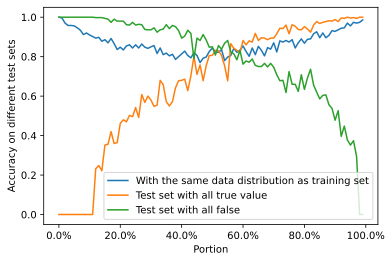

In [17]:
x = list(range(100))
for i,k in enumerate(x):
    x[i]=k/100
plt.plot(x,acc_l, label = 'With the same data distribution as training set')
plt.plot(x,high_acc, label = 'Test set with all true value')
plt.plot(x,low_acc, label = 'Test set with all false')
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.legend(loc = 'best')
plt.xlabel('Portion')
plt.ylabel('Accuracy on different test sets')
plt.savefig('Accuracy on different test sets', dpi=500, bbox_inches='tight')
plt.show()

In [18]:
# for i in range (2000):
#     torch.save(get_model_paras(portion = i%100), 'meta_train/'+ str(i) +'.pt')    
#     ## e.g. if the index is 218, the percentage should be 18%

In [19]:
# for i in range (2000):
#     torch.save(get_model_paras(portion = i%100), 'data_acc/'+ str(i) +'.pt')   